# Automatic Model Tuning

1. [Introduction](#Introduction)
2. [Create Hyperparameter Tuning Job with Augmented Manifest files](Create-Hyperparameter-Tuning-Job-with-Augmented-Manifest-files)
3. [Launch Hyperparameter Tuning Job](#Launch-Hyperparameter-Tuning-Job)
4. [Analyze Results of Hyperparameter Tuning Job](#Analyze-Results-of-Hyperparameter-Tuning-Job)
    1. [Fetch all results as DataFrame](#Fetch-all-results-as-DataFrame)
    2. [Tuning job results over time](#Tuning-job-results-over-time)
    3. [Analyze correlation between objective metric and individual hyperparameters](#Analyze-correlation-between-objective-metric-and-individual-hyperparameters)
    4. [Final hyperparameters selection](#Final-hyperparameters-selection)
5. [Conclusion](#Conclusion)

## 1. Introduction

In this notebook we will be launching a hyperparameter tuning job and evaluating the results to determine the best parameters for our model.

First, we need to set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import io
import numpy as np
import pickle
import s3fs
import boto3
import re
import time
from time import gmtime, strftime
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()

folder = 'lymph-node-image-classification/'

training_image = retrieve("image-classification", boto3.Session().region_name)

CPU times: user 1.34 s, sys: 91.9 ms, total: 1.43 s
Wall time: 1.63 s


## 2. Create Hyperparameter Tuning Job with [Augmented Manifest files](https://docs.aws.amazon.com/sagemaker/latest/dg/augmented-manifest.html)

In [2]:
# create unique job name
s3 = boto3.client("s3")
job_name_prefix = "34Layer-imageclassification"
job_name = job_name_prefix + "-" + time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())

CPU times: user 47.4 ms, sys: 3.33 ms, total: 50.7 ms
Wall time: 61.1 ms


First, we need to set our input parameters to stream our training data using pipe mode by wrapping our Augmented Manifest files as RecordIO format.

In [4]:
import sagemaker

# file paths
s3_train_key = "lymph-node-image-classification/train"
s3_validation_key = "lymph-node-image-classification/validation"
s3_train_data = "s3://{}/{}/augmented_manifest_train.json".format(bucket, s3_train_key)
s3_validation_data = "s3://{}/{}/augmented_manifest_validation.json".format(bucket, s3_validation_key)

s3_output = "s3://{}/{}/output".format(bucket, job_name_prefix)

s3_input_train = sagemaker.TrainingInput(
    s3_data=s3_train_data, 
    content_type="application/x-recordio", 
    distribution="FullyReplicated",
    s3_data_type="AugmentedManifestFile",
    attribute_names=["image-ref", "class"],
    input_mode="Pipe",
    record_wrapping="RecordIO")

s3_input_validation = sagemaker.TrainingInput(
    s3_data=s3_validation_data, 
    content_type="application/x-recordio",
    distribution="FullyReplicated",
    s3_data_type="AugmentedManifestFile",
    attribute_names=["image-ref", "class"],
    input_mode="Pipe",
    record_wrapping="RecordIO")

We should set checkpoints as seen below if we are going to be using spot instances. However, we will not be making use of them for this particular job, so we can ignore this part.

In [5]:
# Checkpointing
checkpoint_in_bucket="checkpoints"

# The S3 URI to store the checkpoints
checkpoint_s3_bucket="s3://{}/{}/{}".format(bucket, job_name, checkpoint_in_bucket)

# The local path where the model will save its checkpoints in the training container
checkpoint_local_path="/opt/ml/checkpoints"

Next, we need to set up the inputs for SageMaker's [Estimators API](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) for training.
We will train using an ml.p3.2xlarge instance and set the following static hyperparameters.

In [5]:
# Estimator input parameters
sess = sagemaker.Session()
imageclassification = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    input_mode = 'Pipe',
    output_path=s3_output,
    sagemaker_session=sess,
    max_run = 10800, # 3 hrs
    #max_wait = 86400, # 24 hrs
    #use_spot_instances=True,
    # Parameters required to enable checkpointing
    #checkpoint_s3_uri=checkpoint_s3_bucket,
    #checkpoint_local_path=checkpoint_local_path
)

# static hyperparameters for image classification model
imageclassification.set_hyperparameters(
    num_layers=34, 
    image_shape="3,96,96",
    num_classes=2,
    epochs=25,
    num_training_samples=262144,
    precision_dtype="float16",
    augmentation_type="crop", 
)

Next, we will provide hyperparameter ranges for our tuning job to select from. Because we are operating under budget constraints and this can quickly become a very large computing problem, we will stick to the parameters `learning_rate`, `mini_batch_size`, and `optimizer`. We can always go through another iteration and tweak the other hyperparameters once we have a general sense for how these three influence model performance.  

SageMaker gives us a large edge here because unlike classic gridsearch, automatic model tuning uses Bayesian Search to intelligently choose the best hyperparameters and learn from previous training jobs. Using the [HyperparameterTuner API](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html), we will set the max number of parallel jobs = 2 in order to best leverage SageMaker's Bayesian optimization.

We are going to be using `validation accuracy` as our objective metric. Typically, we would want to use something like AUC if there was an imbalance in our positive and negative classes, but they are equally weighted in our data so we can use accuracy.

In [6]:
from time import gmtime, strftime
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

tuning_job_name = "34LPT-imageclass-job-{}".format(strftime("%d-%H-%M-%S", gmtime()))

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.00001, 1.0, scaling_type='Logarithmic'),
    "mini_batch_size": IntegerParameter(16, 64),
    "optimizer": CategoricalParameter(["sgd", "adam", "rmsprop", "nag"]),
}

objective_metric_name = "validation:accuracy" 

# Inputs for HyperparameterTuner
tuner = HyperparameterTuner(
    imageclassification,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type="Maximize",
    max_jobs=25,
    max_parallel_jobs=2,
    early_stopping_type="Auto",
)

## 3. Launch Hyperparameter Tuning Job
Here we launch the tuning job. We can monitor the progress of our jobs within SageMaker.

In [ ]:
tuner.fit(
    {"train": s3_input_train, "validation": s3_input_validation},
    job_name=tuning_job_name,
    include_cls_metadata=False,
)
tuner.wait()

.................

## 4. Analyze Results of Hyperparameter Tuning Job

In [2]:
region = boto3.Session().region_name
sage_client = boto3.Session().client("sagemaker")
tuning_job_name = "34LPT-imageclass-job-01-13-29-44"

In [4]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
df = tuner_metrics.dataframe()
total_time_es = df["TrainingElapsedTimeSeconds"].sum() / 3600
print("The total training time with early stopping is {:.2f} hours".format(total_time_es))
#df["TrainingJobStatus"].value_counts()

The total training time with early stopping is 16.68 hours


In [6]:
from pprint import pprint

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2021, 10, 1, 17, 26, 12, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:accuracy',
                                                 'Value': 0.8365300297737122},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2021, 10, 1, 19, 3, 43, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:513033806411:training-job/34lpt-imageclass-job-01-13-29-44-009-e214dfe7',
 'TrainingJobName': '34LPT-imageclass-job-01-13-29-44-009-e214dfe7',
 'TrainingJobStatus': 'Stopped',
 'TrainingStartTime': datetime.datetime(2021, 10, 1, 17, 29, 25, tzinfo=tzlocal()),
 'TunedHyperParameters': {'learning_rate': '0.0022277949273140597',
                          'mini_batch_size': '35',
                          'optimizer': 'sgd'}}


### a) Fetch all results as DataFrame

We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [9]:
import pandas as pd

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df.head()

Number of training jobs with valid objective: 22
{'lowest': 0.5992010235786438, 'highest': 0.8365300297737122}


,learning_rate,mini_batch_size,optimizer,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
14,0.002228,35.0,sgd,34LPT-imageclass-job-01-13-29-44-009-e214dfe7,Stopped,0.836530,2021-10-01 17:29:25+00:00,2021-10-01 19:03:43+00:00,5658.0
7,0.002387,35.0,sgd,34LPT-imageclass-job-01-13-29-44-016-2ef16ef3,Stopped,0.819881,2021-10-01 19:33:09+00:00,2021-10-01 20:38:36+00:00,3927.0
5,0.002277,28.0,sgd,34LPT-imageclass-job-01-13-29-44-018-6b93f870,Stopped,0.815634,2021-10-01 20:32:52+00:00,2021-10-01 22:17:07+00:00,6255.0
3,0.000389,52.0,sgd,34LPT-imageclass-job-01-13-29-44-020-e371c0f7,Stopped,0.813483,2021-10-01 21:32:26+00:00,2021-10-01 22:04:38+00:00,1932.0
13,0.001759,62.0,sgd,34LPT-imageclass-job-01-13-29-44-010-7088e7d7,Stopped,0.788646,2021-10-01 17:28:47+00:00,2021-10-01 17:51:01+00:00,1334.0


### b) Tuning job results over time

Next, we will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [10]:
#dir(tuner) # view all object attributes
tuner._tuning_job_name

'34LPT-imageclass-job-01-13-29-44'

Using BokehJS, we can plot a scatterplot of performance vs. time for all the jobs and view the parameters using the tooltips.

In [11]:
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper:
    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools="pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset"):
        return [self.hovertool(), standard_tools]


hover = HoverHelper(tuner)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type="datetime")
p.circle(source=df, x="TrainingStartTime", y="FinalObjectiveValue")
show(p)

Loading BokehJS ...

![Performance vs. Time Scatterplot](https://github.com/jrbarclay37/PCam-Image-Classification/blob/main/images/BokehJS_scatter.PNG?raw=True)

### c) Analyze correlation between objective metric and individual hyperparameters

We can also use BokehJS to visualize the correlation between each hyperparameter value and our objective metric.

In [12]:
#Create a graph for each hyperparameter to show its correlation with your objective metric
ranges = tuner.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get("Values"):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0

        vals = hp_range["Values"]
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args["x_range"] = vals

    # Now plot it
    p = figure(
        plot_width=500,
        plot_height=500,
        title="Objective vs %s" % hp_name,
        tools=hover.tools(),
        x_axis_label=hp_name,
        y_axis_label=objective_name,
        **categorical_args,
    )
    p.circle(source=df, x=hp_name, y="FinalObjectiveValue")
    figures.append(p)
show(bokeh.layouts.Column(*figures))

![Performance vs. Mini Batch Size](https://github.com/jrbarclay37/PCam-Image-Classification/blob/main/images/BokehJS_mini_batch.PNG?raw=True)
![Performance vs. Learning Rate](https://github.com/jrbarclay37/PCam-Image-Classification/blob/main/images/BokehJS_learning_rate.PNG?raw=True)
![Performance vs. Optimizer](https://github.com/jrbarclay37/PCam-Image-Classification/blob/main/images/BokehJS_optimizer.PNG?raw=True)

We observe that a learning rate close to 0.002 and mini batch size of 35 performed the best. Stochastic Gradient Descent also outperformed the other optimizers with the other default hyperparameters.

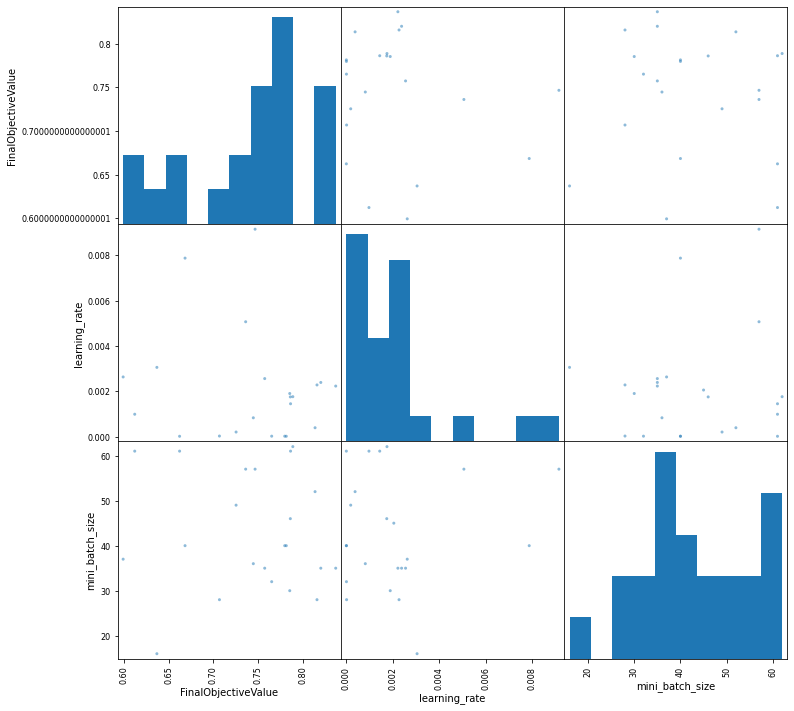

In [39]:
import matplotlib.pyplot as plt

pd.plotting.scatter_matrix(
    df[['FinalObjectiveValue','learning_rate', 'mini_batch_size']],
    figsize=(12, 12)
)
plt.show()

### d) Final hyperparameters selection
* **num_layers**: 34
* **augmentation_type**: `crop`
* **epochs**: 10
* **learning_rate**: 0.009
* **lr_scheduler_factor**: 0.1
* **lr_scheduler_step**: 2,6
* **mini_batch_size**: 64
* **optimizer**: `adam`
* **precision_dtype**: `float16`
* **use_pretrained_model**: 1
* **eps**: 0.1

## Conclusion

Using our hyperparameter tuning results to inform additional rounds of tuning adjustments, we are able to improve from our initial 83% and achieve **89% accuracy** on the validation set through transfer learning with a pre-trained model and using a scheduled learning rate change to reduce by a factor of 0.1 after the 2nd epoch. 

Despite this improved performance, the training accuracy is still quite high (~96%) indicating that the model is overfitting. To solve for this problem, I tried experimenting with regularization terms (weight_decay, betas, etc.) in addition to more learning rate and mini batch size combinations. Unfortunately, these resulted in only marginal improvement and I exceeded my budget for the optimal hyperparameters search. 

With more time and funding, I believe it would be well spent on experimenting with the learning rate schedules to help the model converge. It is also possible that the quality of the data could be a limitation. We may benefit from applying more sophisticated data augmentation methods for this specific use-case where `crop_color_transform` may not be the best for histopathology images.